In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
buy_sessions['product_id'] = buy_sessions['product_id'].astype(str)
buy_sessions['date']=buy_sessions['timestamp'].dt.date
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
df = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
df['product_id'] = df['product_id'].astype(str)

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df=df.groupby(by=[pd.Grouper(key='date', freq='W'), pd.Grouper(key='product_id')]).sum()

In [5]:
print(df)

                       amount
date       product_id        
2019-08-04 1002             3
           1003             0
           1004             0
           1005             0
           1006             1
...                       ...
2021-12-26 1310             0
           1311             0
           1312             0
           1313             0
           1314             0

[24822 rows x 1 columns]


In [6]:
products = pd.read_json("../data/raw/second/products.jsonl", lines=True)
del products['product_name']
products['product_id']=products['product_id'].astype(str)
products.index=products['product_id']
df=df.join(products,on='product_id')

In [7]:
df.index = df.index.get_level_values(0)

In [8]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index.get_level_values(0)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.weekofyear
    del df['date']
    del df['category_path']
    # df=pd.get_dummies(df,columns=['category_path'])
    return df

In [9]:
split_date = pd.to_datetime('2021-09-01')
copy=df.copy()
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

In [10]:
train=create_features(train)
test=create_features(test)

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [11]:
def merge(df1, df2, col,col_name):
    
    df1 =pd.merge(df1, df2, how='left', on=None, left_on=col, right_on=col, right_index=False, sort=True,
             copy=True, indicator=False)
    
    df1 = df1.rename(columns={'amount_y':col_name})
    return df1

[Text(0.5, 0, 'amount'),
 Text(1.5, 0, 'price'),
 Text(2.5, 0, 'quarter'),
 Text(3.5, 0, 'month'),
 Text(4.5, 0, 'year'),
 Text(5.5, 0, 'weekofyear')]

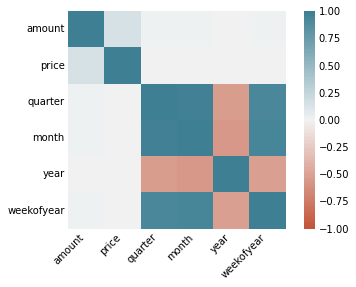

In [12]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [13]:
del train['product_id']
del test['product_id']

In [14]:
X_train=train.copy()
del X_train['amount']
y_train=train['amount']

X_test=test.copy()
del X_test['amount']
y_test=test['amount']

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
test.head(10)

,amount,price,quarter,month,year,weekofyear
date,,,,,,
2021-09-05,0,2048.50,3,9,2021,35
2021-09-05,0,7639.00,3,9,2021,35
2021-09-05,0,49.99,3,9,2021,35
2021-09-05,0,49.99,3,9,2021,35
2021-09-05,0,59.90,3,9,2021,35
2021-09-05,0,89.99,3,9,2021,35
2021-09-05,0,49.99,3,9,2021,35
2021-09-05,0,69.00,3,9,2021,35
2021-09-05,16,89.99,3,9,2021,35


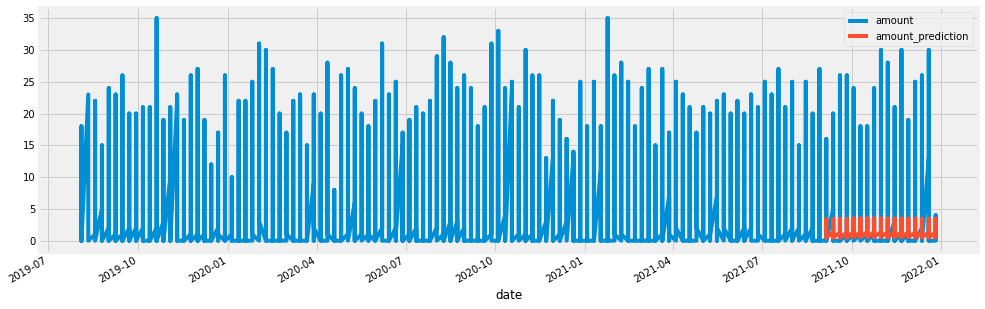

In [16]:
test['amount_prediction'] = model.predict(X_test)
df_all = pd.concat([train, test], sort=False)
_ = df_all[['amount','amount_prediction']].plot(figsize=(15, 5))